# Stocastick Gradient descent
our goal is to predict the house price with a linear regression

remember tetha*X is a strink line -> linear problem

In [35]:
from pathlib import Path
import pandas as pd
import numpy as np

data_file = Path.cwd() / "data-houses" / "train.csv"
print(data_file)
print("Exists:", data_file.exists())

train_data = pd.read_csv(data_file)
# train_data.head()

c:\Users\richy\OneDrive\Desktop\myFile\University\master-degree\first-year\statisticl-and-mathematical-methods\Satistical_and_Mathematical_Methods_for_machine_learning\lesson-5\data-houses\train.csv
Exists: True


We need to preprocess data:
- remove NaN
- convert String in number
- remove useless variables

In [36]:
# Extract interesting features
features = ("LotArea", "OverallQual", "YearBuilt")
X = train_data[list(features)].values

# Reshape the variable to -1,1.  (-1 means "unspecified", so numpy will figure it out).
# Transform Y in a column vector
Y = train_data["SalePrice"].values.reshape(-1, 1)

# Normalize data (witout this step the solution will not converge).
# Some data have very different scales (ex 10^1 vs 10^3). We need to normalize them to have similar scales.
# in this way all the features will have the same importance during the training phase.
X = (X - X.mean(axis=0)) / X.std(axis=0) # subtract mean and divide by std deviation
Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)
# now our date should looks like a standard normal distribution


# now we apply a transformation to apply the bias term
# bias term by defult is not multiplied by X. infact Y = theta * X + bias
# ma siccome lavoriamo con matrici è troppo complicato tenere separato il bias
# quindi aggiungiamo una colonna di 1 in testa a X, in questo modo il primo valore dell vettore theta
# sarà il bias e la moltiplicazione matriciale funzionerà lo stesso
X = np.hstack([np.ones((X.shape[0], 1)), X])  # add a column of ones at the beginning
print("X shape:", X.shape)
N,d = X.shape
# il vero bias è theta[0] la x[:,0] = 1 serve selo per fare in modo che  theta[0]*x[:,0] = theta[0]*1 = bias
print(f"Number of samples: {N}, number of features(colonne): {d} including bias (prima colonna of ones)") 


X shape: (1460, 4)
Number of samples: 1460, number of features(colonne): 4 including bias (prima colonna of ones)


In [37]:
def sigmoid(t):
    return 1.0 / (1.0 + np.exp(-t))

In [ ]:
# Loss and gradient (redefine to be sure)
def l(Theta, X, Y):
    return np.mean(np.square(X @ Theta - Y))

def grad_l(Theta, X, Y):
    N = X.shape[0]
    return (2/N) * X.T @ (X @ Theta - Y)

def accuracy(Theta, X, Y):
    preds = sigmoid(X @ Theta) >= 0.5
    return (preds == Y).mean()

def SGD(l, grad_l, X, Y, Theta0, lr=1e-2, batch_size=32, epochs=10):
    # Save the value of the loss over the iterations
    loss_val = []

    # Save the value of the accuracy over the iterations
    acc_val = []

    Theta = Theta0
    for epoch in range(epochs):
        # Something
        # Step 4: Restart the data and shuffle
        shuffle_idx = np.arange(len(X))
        np.random.shuffle(shuffle_idx)
        X = X[shuffle_idx]
        Y = Y[shuffle_idx]

        n_batches = len(X) // batch_size
        for batch in range(n_batches):
            # Step 1: Randomly sample a batch from data
            Xb = X[batch * batch_size : (batch+1) * batch_size]
            Yb = Y[batch * batch_size : (batch+1) * batch_size]

            # Step 2: Compute the grad_l over Xb, Yb
            g = grad_l(Theta, Xb, Yb)

            # Step 3: Perform one step of GD on g
            Theta = Theta - lr * g

            # Update the loss_val list
            loss_val.append(l(Theta, X, Y))
            acc_val.append(accuracy(Theta, X, Y))
    return Theta, epoch, loss_val, acc_val



In [39]:
# --- Test (adjust variables if your notebook uses other names) ---
# Ensure X, Y exist in the workspace. If not, run the data cells first.
Theta0 = np.zeros((X.shape[1], 1))
Theta, epoch, loss_history, acc_vall = SGD(l, grad_l, X, Y, Theta0, lr=0.01, batch_size=32, epochs=20)

print("Theta shape:", Theta.shape)
print("First 5 loss values:", loss_history[:5])

Theta shape: (4, 1)
First 5 loss values: [np.float64(0.9523401670776045), np.float64(0.8821730223701167), np.float64(0.8467934776215533), np.float64(0.8347298611481159), np.float64(0.8192420077069095)]


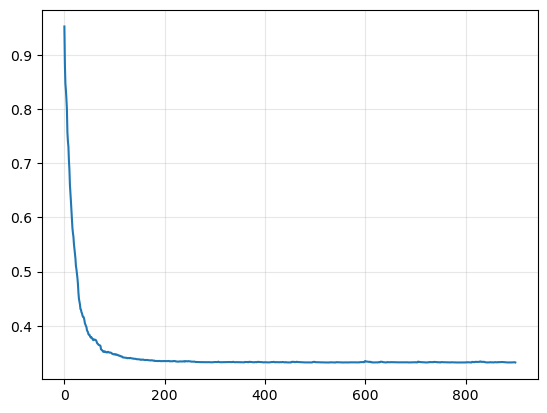

In [40]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.grid(alpha=0.3)
plt.show()

### Adam
è stato dimostrato che non sempre raggiunge la soluzione. ma nella pratica è il metodo più usato

### EMA
calcola la media pesata (B1) del gradiente precedente e del gradiente corrente
ma anche la media pesata (B2) della varienza del gradiente. e la varianza del gradiente allo step precedente

### Note
for very convex problem Normal SGD is better

In [41]:
def adam(l, 
        grad_l,
        Theta0, 
        X, Y, 
        beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=64, 
        lr=1e-3, 
        epochs=500):
    N, d = X.shape
    Theta = Theta0.copy()

    m = np.zeros_like(Theta)
    v = np.zeros_like(Theta)
    t = 0
    losses = []

    for epoch in range(epochs):
        idx = np.random.permutation(N)

        for start in range(0, N, batch_size):
            batch_idx = idx[start:start+batch_size]
            Xb, Yb = X[batch_idx], Y[batch_idx]
            g = grad_l(Theta, Xb, Yb)

            # Adam updates
            t += 1
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            Theta -= lr * (m_hat / (np.sqrt(v_hat) + eps))

            losses.append(l(Theta, X, Y))

    return Theta, losses

Theta_adam, loss_adam = adam(l, grad_l, Theta0, X, Y, batch_size=32, epochs=100, lr=1e-3)


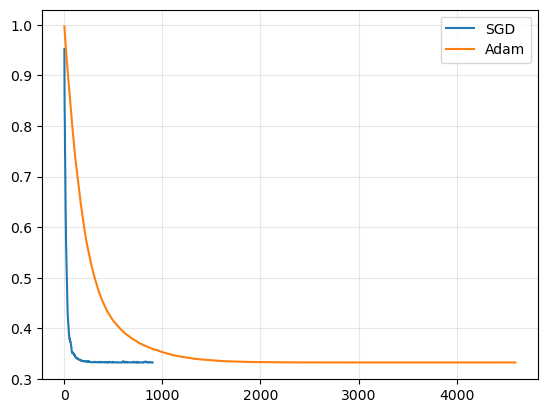

In [42]:
plt.plot(loss_history)
plt.plot(loss_adam)
plt.grid(alpha=0.3)
plt.legend(["SGD", "Adam"])
plt.show()

# Supervised Learning

classification Y can be [0,1] -> 0 first class, 1 second class

multi-class classification are much harden than binary classification

### Sigmoid
can be seen as a probability distribution

siccome la regressione predice una linea. se mettiamo la sigmoide davanati al risultato di tetha*X, esso trasformerà la linea in una probabilità

derivative of sigmoid is very simple
         s'(t) = s(t)(1-s(t))

### Logistic regression
apply sigmoid after the linear regression

### Loss function use for classification

se usassimo la differenza tra la predizione e il risultato f(x)-y
sarebbe come contare i risultati positivi siccome sono tutti 0 e 1  

#### Cross entroy loss

(Yhat) is a prediction

the derivative became -> ((Yhat) - Y)X


###### Accuracy, measure of classification models
conta il numero di classificazioni fatte bene

##### Confision Matrix

True Positive
True Negative
False Positive
False Negative

in base al domionio può importare di più i falsi-positivi o i falsi-negativi 
alcune volte preferiarimo dare un falso-positivo che un negativo.
\\
calculate false positive and false negative:

precision = Tp / (Tp+Fp)   
recall = 

F1 Score:


## Implementation of classification

In [43]:
from pathlib import Path
import pandas as pd

data_file = Path.cwd() / "data-diabetes" / "diabetes.csv"
print(data_file)
print("Exists:", data_file.exists())

df = pd.read_csv(data_file)

c:\Users\richy\OneDrive\Desktop\myFile\University\master-degree\first-year\statisticl-and-mathematical-methods\Satistical_and_Mathematical_Methods_for_machine_learning\lesson-5\data-diabetes\diabetes.csv
Exists: True


In [44]:
X = df.drop("Outcome", axis=1).values   # features
Y = df["Outcome"].values.reshape(-1,1)  # labels

#### N.B: Do Not Standardize the Output,  only the input

In [45]:
# Standardize features
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X = (X - X_mean) / X_std

# Add bias term
X = np.hstack([np.ones((X.shape[0],1)), X])
N, d = X.shape

In [ ]:
# La sigmoid ci da una stima della probabilità che Y = 1 dato X
# la differenza tra theta^T x e Y è o 0 o 1, quindi la loss function diventerebbe una funzione a gradino
# di consegunenza non differenziabile. Per ovviare a questo problema usiamo la sigmoid per approssimare
# la funzione a gradino in modo da avere una loss differenziabile.
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

def l(Theta, X, Y):
    # When you see Theta^T x <-> in matrix form you have
    #                            X @ Theta
    Y_hat = sigmoid(X @ Theta)
    return - np.sum(Y * np.log(Y_hat) + (1-Y) * np.log(1 - Y_hat))

def grad_l(Theta, X, Y):
    Y_hat = sigmoid(X @ Theta)
    return X.T @ (Y_hat - Y)


In [48]:
# Train the model
Theta0 = np.zeros((X.shape[1], 1))
Theta_sgd, _, loss_sgd, acc_sgd = SGD(l, grad_l, X, Y, Theta0, lr=1e-3, batch_size=32, epochs=100)
Theta_adam, loss_adam = adam(l, grad_l, Theta0, X, Y, lr=1e-3, batch_size=32, epochs=100)

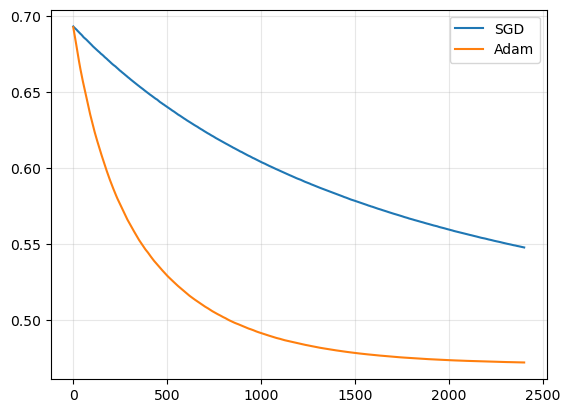

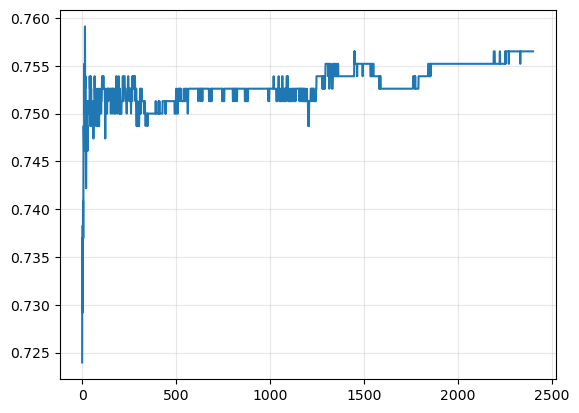

In [50]:
plt.plot(loss_sgd)
plt.plot(loss_adam)
plt.legend(["SGD", "Adam"])
plt.grid(alpha=0.3)
plt.show()

plt.plot(acc_sgd)
plt.grid(alpha=0.3)
plt.show()